# Import necessary packages

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from skimage.io import imshow
from skimage.transform import resize
# from skimage.morphology import label
# from skimage.feature import structure_tensor
from sklearn.model_selection import train_test_split
# from PIL import Image, ImageDraw
# import cv2

import tensorflow as tf

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


## Define custom functions

In [2]:
# Convolution block
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

# Create u-net model
def get_unet(input_img, n_filters = 64, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

# Compute Intersection over union (IoU), a measure of labelling accuracy
# NOTE: This is sometimes also called Jaccard score
def IoU(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

## APONEUROSIS TRAINING

# Set image scaling parameters, determine no. of images for training

In [3]:
# Images will be re-scaled
im_width = 512
im_height = 512
border = 5

# list of all images in the path
ids = next(os.walk("apo_images"))[2] 
print("Total no. of aponeurosis images = ", len(ids))
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

Total no. of aponeurosis images =  574


# Load images and corresponding labels (masks)

In [4]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("apo_images/"+id_, color_mode='grayscale')
    x_img = img_to_array(img)
    x_img = resize(x_img, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("apo_masks/"+id_, color_mode='grayscale'))
    mask = resize(mask, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Normalise and store images
    X[n] = x_img/255.0
    y[n] = mask/255.0

C:\Users\neilj\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


# Set up aponeurosis training

In [6]:
# Split data into training and validation
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1) # i.e. 90% training / 10% test split

In [6]:
# Visualize a random image along with the mask (not necessary, just for checking)
#ix = random.randint(0, len(X_train))
#has_mask = y_train[ix].max() > 0 # Check whether there's at least 1 aponeurosis
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))
#ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
# if has_mask: # if at least 1 aponeurosis is present
    # draw the aponeuroses on the original image
#     ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
# ax1.set_title('Original image')
# ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
# ax2.set_title('Mask only')

In [7]:
# Compile the aponeurosis model
input_img = Input((im_height, im_width, 1), name='img')
model_apo = get_unet(input_img, n_filters=64, dropout=0.25, batchnorm=True)
model_apo.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", IoU])

In [8]:
# Show a summary of the model structure
model_apo.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 640         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 512, 512, 64) 256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 512, 512, 64) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

In [9]:
# Set some training parameters
callbacks = [
    EarlyStopping(patience=8, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-apo2-nc.h5', verbose=1, save_best_only=True, save_weights_only=False), # Give the model a name (the .h5 part)
    CSVLogger('apo2_weights.csv', separator=',', append=False)
]

# Train the aponeurosis model (keep batch size small!)

In [10]:
results = model_apo.fit(X_train, y_train, batch_size=2, epochs=60, callbacks=callbacks, validation_data=(X_valid, y_valid))

Train on 516 samples, validate on 58 samples
Epoch 1/60
304/516 [================>.............] - ETA: 47:22 - loss: 0.5634 - acc: 0.7641 - IoU: 0.72 - ETA: 24:13 - loss: 0.5395 - acc: 0.7862 - IoU: 0.74 - ETA: 16:31 - loss: 0.5115 - acc: 0.8076 - IoU: 0.74 - ETA: 12:39 - loss: 0.4852 - acc: 0.8313 - IoU: 0.75 - ETA: 10:20 - loss: 0.4663 - acc: 0.8477 - IoU: 0.76 - ETA: 8:47 - loss: 0.4472 - acc: 0.8612 - IoU: 0.7672 - ETA: 7:41 - loss: 0.4353 - acc: 0.8736 - IoU: 0.769 - ETA: 6:51 - loss: 0.4198 - acc: 0.8838 - IoU: 0.774 - ETA: 6:12 - loss: 0.4061 - acc: 0.8912 - IoU: 0.779 - ETA: 5:41 - loss: 0.3956 - acc: 0.8963 - IoU: 0.784 - ETA: 5:15 - loss: 0.3819 - acc: 0.9029 - IoU: 0.788 - ETA: 4:54 - loss: 0.3687 - acc: 0.9086 - IoU: 0.794 - ETA: 4:36 - loss: 0.3569 - acc: 0.9124 - IoU: 0.799 - ETA: 4:20 - loss: 0.3460 - acc: 0.9162 - IoU: 0.804 - ETA: 4:07 - loss: 0.3357 - acc: 0.9193 - IoU: 0.809 - ETA: 3:55 - loss: 0.3266 - acc: 0.9220 - IoU: 0.814 - ETA: 3:45 - loss: 0.3170 - acc: 0.92

308/516 [================>.............] - ETA: 1:23 - loss: 0.0523 - acc: 0.9791 - IoU: 0.974 - ETA: 1:24 - loss: 0.0569 - acc: 0.9794 - IoU: 0.973 - ETA: 1:24 - loss: 0.0541 - acc: 0.9795 - IoU: 0.974 - ETA: 1:24 - loss: 0.0713 - acc: 0.9745 - IoU: 0.971 - ETA: 1:24 - loss: 0.0661 - acc: 0.9762 - IoU: 0.972 - ETA: 1:23 - loss: 0.0621 - acc: 0.9775 - IoU: 0.973 - ETA: 1:23 - loss: 0.0603 - acc: 0.9780 - IoU: 0.974 - ETA: 1:22 - loss: 0.0571 - acc: 0.9792 - IoU: 0.974 - ETA: 1:22 - loss: 0.0580 - acc: 0.9790 - IoU: 0.975 - ETA: 1:22 - loss: 0.0584 - acc: 0.9787 - IoU: 0.975 - ETA: 1:22 - loss: 0.0581 - acc: 0.9786 - IoU: 0.975 - ETA: 1:21 - loss: 0.0734 - acc: 0.9747 - IoU: 0.974 - ETA: 1:21 - loss: 0.0713 - acc: 0.9753 - IoU: 0.974 - ETA: 1:21 - loss: 0.0702 - acc: 0.9755 - IoU: 0.974 - ETA: 1:20 - loss: 0.0683 - acc: 0.9760 - IoU: 0.974 - ETA: 1:20 - loss: 0.0688 - acc: 0.9757 - IoU: 0.974 - ETA: 1:20 - loss: 0.0677 - acc: 0.9760 - IoU: 0.974 - ETA: 1:19 - loss: 0.0665 - acc: 0.9763 

516/516 [==============================] - ETA: 34s - loss: 0.0536 - acc: 0.9791 - IoU: 0.97 - ETA: 34s - loss: 0.0535 - acc: 0.9792 - IoU: 0.97 - ETA: 33s - loss: 0.0535 - acc: 0.9792 - IoU: 0.97 - ETA: 33s - loss: 0.0533 - acc: 0.9792 - IoU: 0.97 - ETA: 33s - loss: 0.0533 - acc: 0.9792 - IoU: 0.97 - ETA: 32s - loss: 0.0532 - acc: 0.9793 - IoU: 0.97 - ETA: 32s - loss: 0.0531 - acc: 0.9793 - IoU: 0.97 - ETA: 32s - loss: 0.0531 - acc: 0.9793 - IoU: 0.97 - ETA: 31s - loss: 0.0531 - acc: 0.9793 - IoU: 0.97 - ETA: 31s - loss: 0.0532 - acc: 0.9792 - IoU: 0.97 - ETA: 31s - loss: 0.0530 - acc: 0.9793 - IoU: 0.97 - ETA: 30s - loss: 0.0529 - acc: 0.9793 - IoU: 0.97 - ETA: 30s - loss: 0.0529 - acc: 0.9793 - IoU: 0.97 - ETA: 30s - loss: 0.0532 - acc: 0.9792 - IoU: 0.97 - ETA: 29s - loss: 0.0531 - acc: 0.9792 - IoU: 0.97 - ETA: 29s - loss: 0.0529 - acc: 0.9793 - IoU: 0.97 - ETA: 29s - loss: 0.0530 - acc: 0.9792 - IoU: 0.97 - ETA: 28s - loss: 0.0533 - acc: 0.9791 - IoU: 0.97 - ETA: 28s - loss: 0.05

308/516 [================>.............] - ETA: 1:25 - loss: 0.0398 - acc: 0.9824 - IoU: 0.985 - ETA: 1:25 - loss: 0.0339 - acc: 0.9842 - IoU: 0.986 - ETA: 1:25 - loss: 0.0377 - acc: 0.9830 - IoU: 0.986 - ETA: 1:25 - loss: 0.0348 - acc: 0.9844 - IoU: 0.986 - ETA: 1:24 - loss: 0.0359 - acc: 0.9837 - IoU: 0.986 - ETA: 1:24 - loss: 0.0537 - acc: 0.9793 - IoU: 0.984 - ETA: 1:24 - loss: 0.0518 - acc: 0.9794 - IoU: 0.984 - ETA: 1:23 - loss: 0.0508 - acc: 0.9794 - IoU: 0.984 - ETA: 1:23 - loss: 0.0486 - acc: 0.9802 - IoU: 0.984 - ETA: 1:23 - loss: 0.0485 - acc: 0.9801 - IoU: 0.984 - ETA: 1:22 - loss: 0.0464 - acc: 0.9808 - IoU: 0.984 - ETA: 1:22 - loss: 0.0453 - acc: 0.9811 - IoU: 0.985 - ETA: 1:22 - loss: 0.0439 - acc: 0.9815 - IoU: 0.985 - ETA: 1:21 - loss: 0.0424 - acc: 0.9821 - IoU: 0.985 - ETA: 1:21 - loss: 0.0426 - acc: 0.9820 - IoU: 0.985 - ETA: 1:21 - loss: 0.0426 - acc: 0.9821 - IoU: 0.985 - ETA: 1:20 - loss: 0.0416 - acc: 0.9824 - IoU: 0.985 - ETA: 1:20 - loss: 0.0423 - acc: 0.9819 

516/516 [==============================] - ETA: 34s - loss: 0.0438 - acc: 0.9815 - IoU: 0.98 - ETA: 34s - loss: 0.0445 - acc: 0.9814 - IoU: 0.98 - ETA: 33s - loss: 0.0444 - acc: 0.9814 - IoU: 0.98 - ETA: 33s - loss: 0.0443 - acc: 0.9814 - IoU: 0.98 - ETA: 33s - loss: 0.0443 - acc: 0.9814 - IoU: 0.98 - ETA: 32s - loss: 0.0452 - acc: 0.9812 - IoU: 0.98 - ETA: 32s - loss: 0.0452 - acc: 0.9812 - IoU: 0.98 - ETA: 32s - loss: 0.0451 - acc: 0.9812 - IoU: 0.98 - ETA: 31s - loss: 0.0451 - acc: 0.9812 - IoU: 0.98 - ETA: 31s - loss: 0.0451 - acc: 0.9812 - IoU: 0.98 - ETA: 31s - loss: 0.0451 - acc: 0.9812 - IoU: 0.98 - ETA: 30s - loss: 0.0454 - acc: 0.9811 - IoU: 0.98 - ETA: 30s - loss: 0.0455 - acc: 0.9811 - IoU: 0.98 - ETA: 30s - loss: 0.0455 - acc: 0.9811 - IoU: 0.98 - ETA: 29s - loss: 0.0454 - acc: 0.9811 - IoU: 0.98 - ETA: 29s - loss: 0.0453 - acc: 0.9812 - IoU: 0.98 - ETA: 29s - loss: 0.0452 - acc: 0.9812 - IoU: 0.98 - ETA: 28s - loss: 0.0452 - acc: 0.9812 - IoU: 0.98 - ETA: 28s - loss: 0.04

308/516 [================>.............] - ETA: 1:26 - loss: 0.0232 - acc: 0.9872 - IoU: 0.989 - ETA: 1:26 - loss: 0.0245 - acc: 0.9872 - IoU: 0.989 - ETA: 1:25 - loss: 0.0311 - acc: 0.9843 - IoU: 0.988 - ETA: 1:25 - loss: 0.0287 - acc: 0.9851 - IoU: 0.988 - ETA: 1:25 - loss: 0.0295 - acc: 0.9850 - IoU: 0.988 - ETA: 1:24 - loss: 0.0346 - acc: 0.9834 - IoU: 0.987 - ETA: 1:24 - loss: 0.0342 - acc: 0.9834 - IoU: 0.987 - ETA: 1:24 - loss: 0.0328 - acc: 0.9839 - IoU: 0.988 - ETA: 1:24 - loss: 0.0328 - acc: 0.9839 - IoU: 0.988 - ETA: 1:23 - loss: 0.0321 - acc: 0.9842 - IoU: 0.988 - ETA: 1:23 - loss: 0.0320 - acc: 0.9842 - IoU: 0.988 - ETA: 1:23 - loss: 0.0334 - acc: 0.9837 - IoU: 0.987 - ETA: 1:22 - loss: 0.0342 - acc: 0.9834 - IoU: 0.987 - ETA: 1:22 - loss: 0.0337 - acc: 0.9837 - IoU: 0.987 - ETA: 1:22 - loss: 0.0349 - acc: 0.9831 - IoU: 0.987 - ETA: 1:21 - loss: 0.0345 - acc: 0.9834 - IoU: 0.987 - ETA: 1:21 - loss: 0.0343 - acc: 0.9834 - IoU: 0.987 - ETA: 1:21 - loss: 0.0340 - acc: 0.9836 

516/516 [==============================] - ETA: 34s - loss: 0.0380 - acc: 0.9827 - IoU: 0.98 - ETA: 34s - loss: 0.0383 - acc: 0.9826 - IoU: 0.98 - ETA: 34s - loss: 0.0383 - acc: 0.9826 - IoU: 0.98 - ETA: 33s - loss: 0.0382 - acc: 0.9827 - IoU: 0.98 - ETA: 33s - loss: 0.0382 - acc: 0.9827 - IoU: 0.98 - ETA: 33s - loss: 0.0381 - acc: 0.9827 - IoU: 0.98 - ETA: 32s - loss: 0.0381 - acc: 0.9827 - IoU: 0.98 - ETA: 32s - loss: 0.0380 - acc: 0.9827 - IoU: 0.98 - ETA: 32s - loss: 0.0381 - acc: 0.9827 - IoU: 0.98 - ETA: 31s - loss: 0.0380 - acc: 0.9827 - IoU: 0.98 - ETA: 31s - loss: 0.0380 - acc: 0.9827 - IoU: 0.98 - ETA: 30s - loss: 0.0379 - acc: 0.9827 - IoU: 0.98 - ETA: 30s - loss: 0.0379 - acc: 0.9828 - IoU: 0.98 - ETA: 30s - loss: 0.0385 - acc: 0.9826 - IoU: 0.98 - ETA: 29s - loss: 0.0385 - acc: 0.9826 - IoU: 0.98 - ETA: 29s - loss: 0.0384 - acc: 0.9826 - IoU: 0.98 - ETA: 29s - loss: 0.0383 - acc: 0.9826 - IoU: 0.98 - ETA: 28s - loss: 0.0382 - acc: 0.9827 - IoU: 0.98 - ETA: 28s - loss: 0.03

308/516 [================>.............] - ETA: 1:26 - loss: 0.0281 - acc: 0.9862 - IoU: 0.987 - ETA: 1:25 - loss: 0.0348 - acc: 0.9834 - IoU: 0.987 - ETA: 1:25 - loss: 0.0412 - acc: 0.9810 - IoU: 0.985 - ETA: 1:25 - loss: 0.0376 - acc: 0.9825 - IoU: 0.986 - ETA: 1:24 - loss: 0.0353 - acc: 0.9835 - IoU: 0.986 - ETA: 1:24 - loss: 0.0357 - acc: 0.9833 - IoU: 0.986 - ETA: 1:24 - loss: 0.0348 - acc: 0.9836 - IoU: 0.986 - ETA: 1:24 - loss: 0.0335 - acc: 0.9841 - IoU: 0.986 - ETA: 1:23 - loss: 0.0416 - acc: 0.9818 - IoU: 0.985 - ETA: 1:23 - loss: 0.0400 - acc: 0.9824 - IoU: 0.985 - ETA: 1:23 - loss: 0.0392 - acc: 0.9826 - IoU: 0.986 - ETA: 1:22 - loss: 0.0395 - acc: 0.9823 - IoU: 0.985 - ETA: 1:22 - loss: 0.0383 - acc: 0.9829 - IoU: 0.986 - ETA: 1:22 - loss: 0.0371 - acc: 0.9833 - IoU: 0.986 - ETA: 1:21 - loss: 0.0360 - acc: 0.9838 - IoU: 0.986 - ETA: 1:21 - loss: 0.0361 - acc: 0.9837 - IoU: 0.986 - ETA: 1:21 - loss: 0.0355 - acc: 0.9839 - IoU: 0.986 - ETA: 1:20 - loss: 0.0355 - acc: 0.9838 

516/516 [==============================] - ETA: 34s - loss: 0.0394 - acc: 0.9824 - IoU: 0.98 - ETA: 34s - loss: 0.0393 - acc: 0.9824 - IoU: 0.98 - ETA: 33s - loss: 0.0396 - acc: 0.9824 - IoU: 0.98 - ETA: 33s - loss: 0.0395 - acc: 0.9824 - IoU: 0.98 - ETA: 33s - loss: 0.0394 - acc: 0.9824 - IoU: 0.98 - ETA: 32s - loss: 0.0400 - acc: 0.9823 - IoU: 0.98 - ETA: 32s - loss: 0.0398 - acc: 0.9823 - IoU: 0.98 - ETA: 32s - loss: 0.0398 - acc: 0.9823 - IoU: 0.98 - ETA: 31s - loss: 0.0398 - acc: 0.9823 - IoU: 0.98 - ETA: 31s - loss: 0.0400 - acc: 0.9823 - IoU: 0.98 - ETA: 31s - loss: 0.0399 - acc: 0.9823 - IoU: 0.98 - ETA: 30s - loss: 0.0398 - acc: 0.9823 - IoU: 0.98 - ETA: 30s - loss: 0.0398 - acc: 0.9824 - IoU: 0.98 - ETA: 30s - loss: 0.0397 - acc: 0.9824 - IoU: 0.98 - ETA: 29s - loss: 0.0398 - acc: 0.9823 - IoU: 0.98 - ETA: 29s - loss: 0.0397 - acc: 0.9824 - IoU: 0.98 - ETA: 29s - loss: 0.0396 - acc: 0.9824 - IoU: 0.98 - ETA: 28s - loss: 0.0399 - acc: 0.9823 - IoU: 0.98 - ETA: 28s - loss: 0.03

308/516 [================>.............] - ETA: 1:26 - loss: 0.0315 - acc: 0.9852 - IoU: 0.986 - ETA: 1:25 - loss: 0.0242 - acc: 0.9879 - IoU: 0.989 - ETA: 1:25 - loss: 0.0312 - acc: 0.9849 - IoU: 0.987 - ETA: 1:25 - loss: 0.0294 - acc: 0.9856 - IoU: 0.988 - ETA: 1:25 - loss: 0.0285 - acc: 0.9860 - IoU: 0.988 - ETA: 1:24 - loss: 0.0271 - acc: 0.9864 - IoU: 0.988 - ETA: 1:24 - loss: 0.0255 - acc: 0.9870 - IoU: 0.989 - ETA: 1:23 - loss: 0.0361 - acc: 0.9840 - IoU: 0.988 - ETA: 1:23 - loss: 0.0348 - acc: 0.9843 - IoU: 0.988 - ETA: 1:23 - loss: 0.0339 - acc: 0.9845 - IoU: 0.988 - ETA: 1:22 - loss: 0.0332 - acc: 0.9848 - IoU: 0.988 - ETA: 1:22 - loss: 0.0320 - acc: 0.9852 - IoU: 0.988 - ETA: 1:22 - loss: 0.0314 - acc: 0.9854 - IoU: 0.989 - ETA: 1:21 - loss: 0.0313 - acc: 0.9855 - IoU: 0.988 - ETA: 1:21 - loss: 0.0304 - acc: 0.9859 - IoU: 0.989 - ETA: 1:21 - loss: 0.0302 - acc: 0.9859 - IoU: 0.989 - ETA: 1:20 - loss: 0.0300 - acc: 0.9862 - IoU: 0.989 - ETA: 1:20 - loss: 0.0293 - acc: 0.9863 

516/516 [==============================] - ETA: 34s - loss: 0.0368 - acc: 0.9831 - IoU: 0.98 - ETA: 34s - loss: 0.0367 - acc: 0.9831 - IoU: 0.98 - ETA: 33s - loss: 0.0367 - acc: 0.9831 - IoU: 0.98 - ETA: 33s - loss: 0.0366 - acc: 0.9832 - IoU: 0.98 - ETA: 33s - loss: 0.0365 - acc: 0.9832 - IoU: 0.98 - ETA: 32s - loss: 0.0366 - acc: 0.9832 - IoU: 0.98 - ETA: 32s - loss: 0.0368 - acc: 0.9831 - IoU: 0.98 - ETA: 32s - loss: 0.0368 - acc: 0.9831 - IoU: 0.98 - ETA: 31s - loss: 0.0368 - acc: 0.9831 - IoU: 0.98 - ETA: 31s - loss: 0.0367 - acc: 0.9831 - IoU: 0.98 - ETA: 31s - loss: 0.0367 - acc: 0.9832 - IoU: 0.98 - ETA: 30s - loss: 0.0368 - acc: 0.9831 - IoU: 0.98 - ETA: 30s - loss: 0.0368 - acc: 0.9831 - IoU: 0.98 - ETA: 30s - loss: 0.0368 - acc: 0.9831 - IoU: 0.98 - ETA: 29s - loss: 0.0368 - acc: 0.9831 - IoU: 0.98 - ETA: 29s - loss: 0.0368 - acc: 0.9831 - IoU: 0.98 - ETA: 29s - loss: 0.0368 - acc: 0.9831 - IoU: 0.98 - ETA: 28s - loss: 0.0368 - acc: 0.9831 - IoU: 0.98 - ETA: 28s - loss: 0.03

308/516 [================>.............] - ETA: 1:25 - loss: 0.0193 - acc: 0.9907 - IoU: 0.992 - ETA: 1:25 - loss: 0.0209 - acc: 0.9890 - IoU: 0.991 - ETA: 1:25 - loss: 0.0399 - acc: 0.9826 - IoU: 0.988 - ETA: 1:25 - loss: 0.0358 - acc: 0.9839 - IoU: 0.988 - ETA: 1:24 - loss: 0.0363 - acc: 0.9833 - IoU: 0.987 - ETA: 1:24 - loss: 0.0330 - acc: 0.9846 - IoU: 0.988 - ETA: 1:24 - loss: 0.0323 - acc: 0.9847 - IoU: 0.988 - ETA: 1:23 - loss: 0.0324 - acc: 0.9846 - IoU: 0.987 - ETA: 1:23 - loss: 0.0324 - acc: 0.9843 - IoU: 0.987 - ETA: 1:23 - loss: 0.0315 - acc: 0.9848 - IoU: 0.988 - ETA: 1:22 - loss: 0.0324 - acc: 0.9847 - IoU: 0.988 - ETA: 1:22 - loss: 0.0316 - acc: 0.9850 - IoU: 0.988 - ETA: 1:22 - loss: 0.0312 - acc: 0.9850 - IoU: 0.988 - ETA: 1:21 - loss: 0.0306 - acc: 0.9853 - IoU: 0.988 - ETA: 1:21 - loss: 0.0302 - acc: 0.9854 - IoU: 0.988 - ETA: 1:21 - loss: 0.0299 - acc: 0.9855 - IoU: 0.988 - ETA: 1:20 - loss: 0.0293 - acc: 0.9858 - IoU: 0.988 - ETA: 1:20 - loss: 0.0307 - acc: 0.9854 

516/516 [==============================] - ETA: 34s - loss: 0.0348 - acc: 0.9839 - IoU: 0.98 - ETA: 34s - loss: 0.0347 - acc: 0.9839 - IoU: 0.98 - ETA: 33s - loss: 0.0349 - acc: 0.9838 - IoU: 0.98 - ETA: 33s - loss: 0.0348 - acc: 0.9839 - IoU: 0.98 - ETA: 33s - loss: 0.0348 - acc: 0.9839 - IoU: 0.98 - ETA: 32s - loss: 0.0347 - acc: 0.9839 - IoU: 0.98 - ETA: 32s - loss: 0.0347 - acc: 0.9839 - IoU: 0.98 - ETA: 32s - loss: 0.0351 - acc: 0.9838 - IoU: 0.98 - ETA: 31s - loss: 0.0350 - acc: 0.9838 - IoU: 0.98 - ETA: 31s - loss: 0.0349 - acc: 0.9838 - IoU: 0.98 - ETA: 31s - loss: 0.0353 - acc: 0.9837 - IoU: 0.98 - ETA: 30s - loss: 0.0353 - acc: 0.9837 - IoU: 0.98 - ETA: 30s - loss: 0.0352 - acc: 0.9837 - IoU: 0.98 - ETA: 30s - loss: 0.0353 - acc: 0.9837 - IoU: 0.98 - ETA: 29s - loss: 0.0353 - acc: 0.9837 - IoU: 0.98 - ETA: 29s - loss: 0.0356 - acc: 0.9836 - IoU: 0.98 - ETA: 29s - loss: 0.0357 - acc: 0.9835 - IoU: 0.98 - ETA: 28s - loss: 0.0357 - acc: 0.9835 - IoU: 0.98 - ETA: 28s - loss: 0.03

308/516 [================>.............] - ETA: 1:26 - loss: 0.0291 - acc: 0.9870 - IoU: 0.986 - ETA: 1:25 - loss: 0.0277 - acc: 0.9872 - IoU: 0.987 - ETA: 1:25 - loss: 0.0281 - acc: 0.9870 - IoU: 0.986 - ETA: 1:25 - loss: 0.0276 - acc: 0.9872 - IoU: 0.986 - ETA: 1:25 - loss: 0.0271 - acc: 0.9872 - IoU: 0.987 - ETA: 1:24 - loss: 0.0274 - acc: 0.9871 - IoU: 0.987 - ETA: 1:24 - loss: 0.0316 - acc: 0.9850 - IoU: 0.986 - ETA: 1:24 - loss: 0.0321 - acc: 0.9848 - IoU: 0.986 - ETA: 1:23 - loss: 0.0335 - acc: 0.9840 - IoU: 0.985 - ETA: 1:23 - loss: 0.0330 - acc: 0.9844 - IoU: 0.986 - ETA: 1:23 - loss: 0.0317 - acc: 0.9848 - IoU: 0.986 - ETA: 1:22 - loss: 0.0304 - acc: 0.9853 - IoU: 0.987 - ETA: 1:22 - loss: 0.0304 - acc: 0.9853 - IoU: 0.987 - ETA: 1:22 - loss: 0.0359 - acc: 0.9834 - IoU: 0.986 - ETA: 1:21 - loss: 0.0360 - acc: 0.9833 - IoU: 0.986 - ETA: 1:21 - loss: 0.0351 - acc: 0.9836 - IoU: 0.986 - ETA: 1:21 - loss: 0.0360 - acc: 0.9832 - IoU: 0.986 - ETA: 1:20 - loss: 0.0352 - acc: 0.9834 

516/516 [==============================] - ETA: 34s - loss: 0.0343 - acc: 0.9837 - IoU: 0.98 - ETA: 34s - loss: 0.0343 - acc: 0.9837 - IoU: 0.98 - ETA: 34s - loss: 0.0343 - acc: 0.9837 - IoU: 0.98 - ETA: 33s - loss: 0.0342 - acc: 0.9837 - IoU: 0.98 - ETA: 33s - loss: 0.0343 - acc: 0.9837 - IoU: 0.98 - ETA: 33s - loss: 0.0343 - acc: 0.9837 - IoU: 0.98 - ETA: 32s - loss: 0.0344 - acc: 0.9836 - IoU: 0.98 - ETA: 32s - loss: 0.0345 - acc: 0.9835 - IoU: 0.98 - ETA: 32s - loss: 0.0344 - acc: 0.9836 - IoU: 0.98 - ETA: 31s - loss: 0.0349 - acc: 0.9834 - IoU: 0.98 - ETA: 31s - loss: 0.0350 - acc: 0.9834 - IoU: 0.98 - ETA: 31s - loss: 0.0350 - acc: 0.9834 - IoU: 0.98 - ETA: 30s - loss: 0.0350 - acc: 0.9834 - IoU: 0.98 - ETA: 30s - loss: 0.0350 - acc: 0.9834 - IoU: 0.98 - ETA: 29s - loss: 0.0350 - acc: 0.9834 - IoU: 0.98 - ETA: 29s - loss: 0.0349 - acc: 0.9835 - IoU: 0.98 - ETA: 29s - loss: 0.0348 - acc: 0.9835 - IoU: 0.98 - ETA: 28s - loss: 0.0348 - acc: 0.9835 - IoU: 0.98 - ETA: 28s - loss: 0.03

308/516 [================>.............] - ETA: 1:26 - loss: 0.0231 - acc: 0.9889 - IoU: 0.990 - ETA: 1:25 - loss: 0.0483 - acc: 0.9804 - IoU: 0.986 - ETA: 1:25 - loss: 0.0405 - acc: 0.9824 - IoU: 0.987 - ETA: 1:25 - loss: 0.0353 - acc: 0.9839 - IoU: 0.989 - ETA: 1:24 - loss: 0.0348 - acc: 0.9840 - IoU: 0.988 - ETA: 1:24 - loss: 0.0307 - acc: 0.9858 - IoU: 0.989 - ETA: 1:24 - loss: 0.0289 - acc: 0.9865 - IoU: 0.990 - ETA: 1:24 - loss: 0.0357 - acc: 0.9843 - IoU: 0.989 - ETA: 1:23 - loss: 0.0350 - acc: 0.9846 - IoU: 0.989 - ETA: 1:23 - loss: 0.0339 - acc: 0.9849 - IoU: 0.989 - ETA: 1:23 - loss: 0.0371 - acc: 0.9834 - IoU: 0.988 - ETA: 1:22 - loss: 0.0386 - acc: 0.9823 - IoU: 0.988 - ETA: 1:22 - loss: 0.0375 - acc: 0.9827 - IoU: 0.988 - ETA: 1:22 - loss: 0.0363 - acc: 0.9831 - IoU: 0.988 - ETA: 1:21 - loss: 0.0359 - acc: 0.9833 - IoU: 0.988 - ETA: 1:21 - loss: 0.0347 - acc: 0.9838 - IoU: 0.988 - ETA: 1:21 - loss: 0.0363 - acc: 0.9831 - IoU: 0.988 - ETA: 1:20 - loss: 0.0365 - acc: 0.9827 

516/516 [==============================] - ETA: 34s - loss: 0.0308 - acc: 0.9848 - IoU: 0.98 - ETA: 34s - loss: 0.0308 - acc: 0.9848 - IoU: 0.98 - ETA: 34s - loss: 0.0309 - acc: 0.9847 - IoU: 0.98 - ETA: 33s - loss: 0.0309 - acc: 0.9847 - IoU: 0.98 - ETA: 33s - loss: 0.0308 - acc: 0.9848 - IoU: 0.98 - ETA: 33s - loss: 0.0308 - acc: 0.9847 - IoU: 0.98 - ETA: 32s - loss: 0.0309 - acc: 0.9847 - IoU: 0.98 - ETA: 32s - loss: 0.0309 - acc: 0.9847 - IoU: 0.98 - ETA: 32s - loss: 0.0308 - acc: 0.9847 - IoU: 0.98 - ETA: 31s - loss: 0.0307 - acc: 0.9848 - IoU: 0.98 - ETA: 31s - loss: 0.0307 - acc: 0.9848 - IoU: 0.98 - ETA: 31s - loss: 0.0313 - acc: 0.9846 - IoU: 0.98 - ETA: 30s - loss: 0.0312 - acc: 0.9846 - IoU: 0.98 - ETA: 30s - loss: 0.0311 - acc: 0.9847 - IoU: 0.98 - ETA: 29s - loss: 0.0310 - acc: 0.9847 - IoU: 0.98 - ETA: 29s - loss: 0.0310 - acc: 0.9847 - IoU: 0.98 - ETA: 29s - loss: 0.0310 - acc: 0.9847 - IoU: 0.98 - ETA: 28s - loss: 0.0310 - acc: 0.9847 - IoU: 0.98 - ETA: 28s - loss: 0.03

308/516 [================>.............] - ETA: 1:25 - loss: 0.0228 - acc: 0.9873 - IoU: 0.990 - ETA: 1:25 - loss: 0.0277 - acc: 0.9851 - IoU: 0.990 - ETA: 1:25 - loss: 0.0501 - acc: 0.9788 - IoU: 0.986 - ETA: 1:25 - loss: 0.0572 - acc: 0.9763 - IoU: 0.985 - ETA: 1:24 - loss: 0.0532 - acc: 0.9776 - IoU: 0.985 - ETA: 1:24 - loss: 0.0474 - acc: 0.9793 - IoU: 0.986 - ETA: 1:24 - loss: 0.0454 - acc: 0.9799 - IoU: 0.986 - ETA: 1:23 - loss: 0.0448 - acc: 0.9797 - IoU: 0.986 - ETA: 1:23 - loss: 0.0425 - acc: 0.9805 - IoU: 0.986 - ETA: 1:23 - loss: 0.0427 - acc: 0.9803 - IoU: 0.986 - ETA: 1:23 - loss: 0.0416 - acc: 0.9808 - IoU: 0.986 - ETA: 1:22 - loss: 0.0409 - acc: 0.9810 - IoU: 0.986 - ETA: 1:22 - loss: 0.0389 - acc: 0.9818 - IoU: 0.987 - ETA: 1:22 - loss: 0.0391 - acc: 0.9815 - IoU: 0.987 - ETA: 1:21 - loss: 0.0385 - acc: 0.9818 - IoU: 0.987 - ETA: 1:21 - loss: 0.0370 - acc: 0.9824 - IoU: 0.987 - ETA: 1:21 - loss: 0.0365 - acc: 0.9826 - IoU: 0.987 - ETA: 1:20 - loss: 0.0368 - acc: 0.9823 

516/516 [==============================] - ETA: 34s - loss: 0.0323 - acc: 0.9841 - IoU: 0.98 - ETA: 34s - loss: 0.0322 - acc: 0.9841 - IoU: 0.98 - ETA: 33s - loss: 0.0321 - acc: 0.9842 - IoU: 0.98 - ETA: 33s - loss: 0.0321 - acc: 0.9842 - IoU: 0.98 - ETA: 33s - loss: 0.0321 - acc: 0.9842 - IoU: 0.98 - ETA: 32s - loss: 0.0320 - acc: 0.9842 - IoU: 0.98 - ETA: 32s - loss: 0.0320 - acc: 0.9843 - IoU: 0.98 - ETA: 32s - loss: 0.0319 - acc: 0.9843 - IoU: 0.98 - ETA: 31s - loss: 0.0318 - acc: 0.9843 - IoU: 0.98 - ETA: 31s - loss: 0.0317 - acc: 0.9844 - IoU: 0.98 - ETA: 31s - loss: 0.0317 - acc: 0.9844 - IoU: 0.98 - ETA: 30s - loss: 0.0316 - acc: 0.9844 - IoU: 0.98 - ETA: 30s - loss: 0.0320 - acc: 0.9842 - IoU: 0.98 - ETA: 30s - loss: 0.0320 - acc: 0.9842 - IoU: 0.98 - ETA: 29s - loss: 0.0319 - acc: 0.9843 - IoU: 0.98 - ETA: 29s - loss: 0.0318 - acc: 0.9843 - IoU: 0.98 - ETA: 29s - loss: 0.0319 - acc: 0.9843 - IoU: 0.98 - ETA: 28s - loss: 0.0319 - acc: 0.9843 - IoU: 0.98 - ETA: 28s - loss: 0.03

308/516 [================>.............] - ETA: 1:27 - loss: 0.0285 - acc: 0.9866 - IoU: 0.988 - ETA: 1:26 - loss: 0.0472 - acc: 0.9751 - IoU: 0.983 - ETA: 1:26 - loss: 0.0411 - acc: 0.9786 - IoU: 0.984 - ETA: 1:25 - loss: 0.0364 - acc: 0.9808 - IoU: 0.986 - ETA: 1:25 - loss: 0.0379 - acc: 0.9798 - IoU: 0.986 - ETA: 1:25 - loss: 0.0354 - acc: 0.9812 - IoU: 0.986 - ETA: 1:24 - loss: 0.0333 - acc: 0.9824 - IoU: 0.987 - ETA: 1:24 - loss: 0.0336 - acc: 0.9821 - IoU: 0.987 - ETA: 1:23 - loss: 0.0328 - acc: 0.9827 - IoU: 0.988 - ETA: 1:23 - loss: 0.0314 - acc: 0.9833 - IoU: 0.988 - ETA: 1:23 - loss: 0.0311 - acc: 0.9836 - IoU: 0.988 - ETA: 1:22 - loss: 0.0296 - acc: 0.9843 - IoU: 0.989 - ETA: 1:22 - loss: 0.0294 - acc: 0.9842 - IoU: 0.989 - ETA: 1:22 - loss: 0.0301 - acc: 0.9839 - IoU: 0.989 - ETA: 1:21 - loss: 0.0289 - acc: 0.9844 - IoU: 0.989 - ETA: 1:21 - loss: 0.0285 - acc: 0.9846 - IoU: 0.989 - ETA: 1:21 - loss: 0.0283 - acc: 0.9848 - IoU: 0.989 - ETA: 1:20 - loss: 0.0279 - acc: 0.9849 

516/516 [==============================] - ETA: 34s - loss: 0.0305 - acc: 0.9845 - IoU: 0.98 - ETA: 34s - loss: 0.0305 - acc: 0.9845 - IoU: 0.98 - ETA: 34s - loss: 0.0309 - acc: 0.9844 - IoU: 0.98 - ETA: 33s - loss: 0.0309 - acc: 0.9844 - IoU: 0.98 - ETA: 33s - loss: 0.0309 - acc: 0.9844 - IoU: 0.98 - ETA: 33s - loss: 0.0308 - acc: 0.9844 - IoU: 0.98 - ETA: 32s - loss: 0.0308 - acc: 0.9845 - IoU: 0.98 - ETA: 32s - loss: 0.0309 - acc: 0.9844 - IoU: 0.98 - ETA: 31s - loss: 0.0309 - acc: 0.9844 - IoU: 0.98 - ETA: 31s - loss: 0.0308 - acc: 0.9845 - IoU: 0.98 - ETA: 31s - loss: 0.0308 - acc: 0.9845 - IoU: 0.98 - ETA: 30s - loss: 0.0308 - acc: 0.9845 - IoU: 0.98 - ETA: 30s - loss: 0.0308 - acc: 0.9845 - IoU: 0.98 - ETA: 30s - loss: 0.0308 - acc: 0.9844 - IoU: 0.98 - ETA: 29s - loss: 0.0308 - acc: 0.9845 - IoU: 0.98 - ETA: 29s - loss: 0.0307 - acc: 0.9845 - IoU: 0.98 - ETA: 29s - loss: 0.0307 - acc: 0.9845 - IoU: 0.98 - ETA: 28s - loss: 0.0307 - acc: 0.9845 - IoU: 0.98 - ETA: 28s - loss: 0.03

308/516 [================>.............] - ETA: 1:25 - loss: 0.0159 - acc: 0.9906 - IoU: 0.993 - ETA: 1:25 - loss: 0.0162 - acc: 0.9909 - IoU: 0.993 - ETA: 1:25 - loss: 0.0241 - acc: 0.9870 - IoU: 0.990 - ETA: 1:25 - loss: 0.0324 - acc: 0.9831 - IoU: 0.988 - ETA: 1:25 - loss: 0.0326 - acc: 0.9830 - IoU: 0.988 - ETA: 1:24 - loss: 0.0328 - acc: 0.9829 - IoU: 0.987 - ETA: 1:24 - loss: 0.0334 - acc: 0.9825 - IoU: 0.987 - ETA: 1:24 - loss: 0.0365 - acc: 0.9819 - IoU: 0.987 - ETA: 1:23 - loss: 0.0356 - acc: 0.9820 - IoU: 0.987 - ETA: 1:23 - loss: 0.0353 - acc: 0.9823 - IoU: 0.987 - ETA: 1:22 - loss: 0.0340 - acc: 0.9829 - IoU: 0.988 - ETA: 1:22 - loss: 0.0326 - acc: 0.9836 - IoU: 0.988 - ETA: 1:22 - loss: 0.0342 - acc: 0.9827 - IoU: 0.988 - ETA: 1:21 - loss: 0.0333 - acc: 0.9830 - IoU: 0.988 - ETA: 1:21 - loss: 0.0324 - acc: 0.9834 - IoU: 0.988 - ETA: 1:21 - loss: 0.0325 - acc: 0.9833 - IoU: 0.988 - ETA: 1:20 - loss: 0.0348 - acc: 0.9821 - IoU: 0.987 - ETA: 1:20 - loss: 0.0340 - acc: 0.9825 

516/516 [==============================] - ETA: 34s - loss: 0.0295 - acc: 0.9850 - IoU: 0.98 - ETA: 34s - loss: 0.0294 - acc: 0.9851 - IoU: 0.98 - ETA: 33s - loss: 0.0293 - acc: 0.9851 - IoU: 0.98 - ETA: 33s - loss: 0.0294 - acc: 0.9851 - IoU: 0.98 - ETA: 33s - loss: 0.0293 - acc: 0.9851 - IoU: 0.98 - ETA: 32s - loss: 0.0292 - acc: 0.9851 - IoU: 0.98 - ETA: 32s - loss: 0.0292 - acc: 0.9851 - IoU: 0.98 - ETA: 32s - loss: 0.0293 - acc: 0.9851 - IoU: 0.98 - ETA: 31s - loss: 0.0292 - acc: 0.9851 - IoU: 0.98 - ETA: 31s - loss: 0.0292 - acc: 0.9851 - IoU: 0.98 - ETA: 31s - loss: 0.0293 - acc: 0.9851 - IoU: 0.98 - ETA: 30s - loss: 0.0293 - acc: 0.9851 - IoU: 0.98 - ETA: 30s - loss: 0.0293 - acc: 0.9851 - IoU: 0.98 - ETA: 30s - loss: 0.0292 - acc: 0.9851 - IoU: 0.98 - ETA: 29s - loss: 0.0292 - acc: 0.9851 - IoU: 0.98 - ETA: 29s - loss: 0.0292 - acc: 0.9851 - IoU: 0.98 - ETA: 29s - loss: 0.0291 - acc: 0.9851 - IoU: 0.98 - ETA: 28s - loss: 0.0291 - acc: 0.9851 - IoU: 0.98 - ETA: 28s - loss: 0.02

308/516 [================>.............] - ETA: 1:26 - loss: 0.0158 - acc: 0.9908 - IoU: 0.993 - ETA: 1:25 - loss: 0.0177 - acc: 0.9898 - IoU: 0.992 - ETA: 1:25 - loss: 0.0173 - acc: 0.9899 - IoU: 0.992 - ETA: 1:25 - loss: 0.0185 - acc: 0.9892 - IoU: 0.992 - ETA: 1:24 - loss: 0.0218 - acc: 0.9876 - IoU: 0.991 - ETA: 1:24 - loss: 0.0207 - acc: 0.9881 - IoU: 0.991 - ETA: 1:24 - loss: 0.0224 - acc: 0.9872 - IoU: 0.990 - ETA: 1:24 - loss: 0.0241 - acc: 0.9867 - IoU: 0.990 - ETA: 1:23 - loss: 0.0234 - acc: 0.9870 - IoU: 0.990 - ETA: 1:23 - loss: 0.0226 - acc: 0.9874 - IoU: 0.991 - ETA: 1:23 - loss: 0.0233 - acc: 0.9870 - IoU: 0.990 - ETA: 1:22 - loss: 0.0227 - acc: 0.9874 - IoU: 0.991 - ETA: 1:22 - loss: 0.0228 - acc: 0.9873 - IoU: 0.991 - ETA: 1:22 - loss: 0.0233 - acc: 0.9872 - IoU: 0.991 - ETA: 1:21 - loss: 0.0226 - acc: 0.9875 - IoU: 0.991 - ETA: 1:21 - loss: 0.0222 - acc: 0.9877 - IoU: 0.991 - ETA: 1:21 - loss: 0.0223 - acc: 0.9877 - IoU: 0.991 - ETA: 1:20 - loss: 0.0231 - acc: 0.9873 

516/516 [==============================] - ETA: 34s - loss: 0.0266 - acc: 0.9856 - IoU: 0.99 - ETA: 34s - loss: 0.0265 - acc: 0.9856 - IoU: 0.99 - ETA: 34s - loss: 0.0264 - acc: 0.9857 - IoU: 0.99 - ETA: 33s - loss: 0.0265 - acc: 0.9856 - IoU: 0.99 - ETA: 33s - loss: 0.0265 - acc: 0.9856 - IoU: 0.99 - ETA: 33s - loss: 0.0265 - acc: 0.9856 - IoU: 0.99 - ETA: 32s - loss: 0.0271 - acc: 0.9854 - IoU: 0.99 - ETA: 32s - loss: 0.0270 - acc: 0.9855 - IoU: 0.99 - ETA: 32s - loss: 0.0270 - acc: 0.9855 - IoU: 0.99 - ETA: 31s - loss: 0.0270 - acc: 0.9855 - IoU: 0.99 - ETA: 31s - loss: 0.0270 - acc: 0.9855 - IoU: 0.99 - ETA: 31s - loss: 0.0270 - acc: 0.9855 - IoU: 0.99 - ETA: 30s - loss: 0.0269 - acc: 0.9855 - IoU: 0.99 - ETA: 30s - loss: 0.0269 - acc: 0.9855 - IoU: 0.99 - ETA: 29s - loss: 0.0269 - acc: 0.9855 - IoU: 0.99 - ETA: 29s - loss: 0.0268 - acc: 0.9856 - IoU: 0.99 - ETA: 29s - loss: 0.0269 - acc: 0.9855 - IoU: 0.99 - ETA: 28s - loss: 0.0268 - acc: 0.9856 - IoU: 0.99 - ETA: 28s - loss: 0.02

308/516 [================>.............] - ETA: 1:25 - loss: 0.0322 - acc: 0.9856 - IoU: 0.989 - ETA: 1:25 - loss: 0.0248 - acc: 0.9876 - IoU: 0.990 - ETA: 1:25 - loss: 0.0230 - acc: 0.9885 - IoU: 0.990 - ETA: 1:25 - loss: 0.0226 - acc: 0.9885 - IoU: 0.990 - ETA: 1:24 - loss: 0.0211 - acc: 0.9891 - IoU: 0.991 - ETA: 1:24 - loss: 0.0212 - acc: 0.9888 - IoU: 0.991 - ETA: 1:24 - loss: 0.0214 - acc: 0.9888 - IoU: 0.991 - ETA: 1:23 - loss: 0.0212 - acc: 0.9888 - IoU: 0.991 - ETA: 1:23 - loss: 0.0208 - acc: 0.9890 - IoU: 0.991 - ETA: 1:23 - loss: 0.0211 - acc: 0.9889 - IoU: 0.991 - ETA: 1:22 - loss: 0.0209 - acc: 0.9890 - IoU: 0.991 - ETA: 1:22 - loss: 0.0205 - acc: 0.9892 - IoU: 0.991 - ETA: 1:22 - loss: 0.0204 - acc: 0.9892 - IoU: 0.991 - ETA: 1:21 - loss: 0.0202 - acc: 0.9892 - IoU: 0.991 - ETA: 1:21 - loss: 0.0201 - acc: 0.9893 - IoU: 0.991 - ETA: 1:21 - loss: 0.0237 - acc: 0.9875 - IoU: 0.991 - ETA: 1:21 - loss: 0.0230 - acc: 0.9878 - IoU: 0.991 - ETA: 1:20 - loss: 0.0230 - acc: 0.9879 

516/516 [==============================] - ETA: 34s - loss: 0.0265 - acc: 0.9857 - IoU: 0.99 - ETA: 34s - loss: 0.0264 - acc: 0.9857 - IoU: 0.99 - ETA: 33s - loss: 0.0264 - acc: 0.9858 - IoU: 0.99 - ETA: 33s - loss: 0.0263 - acc: 0.9858 - IoU: 0.99 - ETA: 33s - loss: 0.0262 - acc: 0.9858 - IoU: 0.99 - ETA: 32s - loss: 0.0265 - acc: 0.9857 - IoU: 0.99 - ETA: 32s - loss: 0.0265 - acc: 0.9857 - IoU: 0.99 - ETA: 32s - loss: 0.0264 - acc: 0.9857 - IoU: 0.99 - ETA: 31s - loss: 0.0266 - acc: 0.9857 - IoU: 0.99 - ETA: 31s - loss: 0.0265 - acc: 0.9857 - IoU: 0.99 - ETA: 31s - loss: 0.0265 - acc: 0.9857 - IoU: 0.99 - ETA: 30s - loss: 0.0265 - acc: 0.9857 - IoU: 0.99 - ETA: 30s - loss: 0.0264 - acc: 0.9857 - IoU: 0.99 - ETA: 30s - loss: 0.0264 - acc: 0.9857 - IoU: 0.99 - ETA: 29s - loss: 0.0263 - acc: 0.9858 - IoU: 0.99 - ETA: 29s - loss: 0.0263 - acc: 0.9858 - IoU: 0.99 - ETA: 29s - loss: 0.0262 - acc: 0.9858 - IoU: 0.99 - ETA: 28s - loss: 0.0262 - acc: 0.9858 - IoU: 0.99 - ETA: 28s - loss: 0.02

## Visualise the results of training

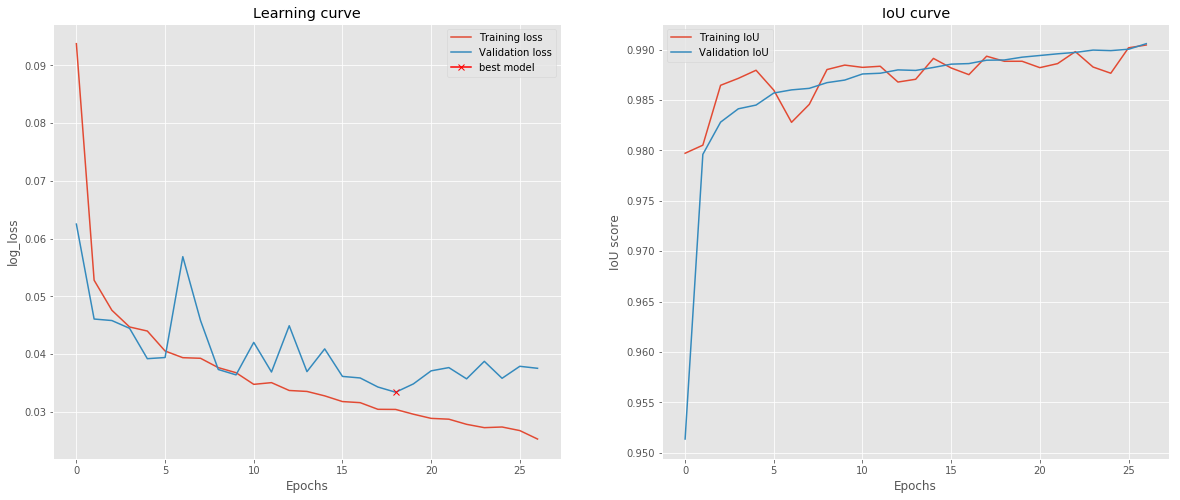

In [11]:
# Variables stored in results.history: val_loss, val_acc, val_IoU, loss, acc, IoU, lr
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(results.history["loss"], label="Training loss")
ax[0].plot(results.history["val_loss"], label="Validation loss")
ax[0].set_title('Learning curve')
ax[0].plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log_loss")
ax[0].legend();

ax[1].plot(results.history["val_IoU"], label="Training IoU")
ax[1].plot(results.history["IoU"], label="Validation IoU")
ax[1].set_title("IoU curve")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU score")
ax[1].legend();

In [17]:
# results.history # Show the loss values (these are saved to a .csv file using 'CSVLogger' callback defined above)

In [ ]:
# Predict on training and validations sets
preds_train = model_apo.predict(X_train, verbose=1)
preds_val = model_apo.predict(X_valid, verbose=1)

# Threshold predictions (only keep predictions with a minimum level of confidence)
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

## END OF APONEUROSIS MODEL TRAINING - NOW USE THE TRAINED MODEL BY RUNNING ONE OF THE INFERENCE NOTEBOOKS

# Start of Fascicle Training

In [18]:
# list of names of all images in the given path
im_width = 512
im_height = 512
idsF = next(os.walk("fasc_images_S"))[2] 
print("Total no. of fascicle images = ", len(idsF))
XF = np.zeros((len(idsF), im_height, im_width, 1), dtype=np.float32)
yF = np.zeros((len(idsF), im_height, im_width, 1), dtype=np.float32)

Total no. of fascicle images =  309


# Load images and corresponding fascicle masks

In [19]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(idsF), total=len(idsF)):
    # Load images
    imgF = load_img("fasc_images_S/"+id_, color_mode = 'grayscale')
    x_imgF = img_to_array(imgF)
    x_imgF = resize(x_imgF, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Load masks
    maskF = img_to_array(load_img("fasc_masks_S/"+id_, color_mode = 'grayscale'))
    maskF = resize(maskF, (512, 512, 1), mode = 'constant', preserve_range = True)
    # Normalise and store images
    XF[n] = x_imgF/255.0
    yF[n] = maskF/255.0

C:\Users\neilj\AppData\Local\Continuum\anaconda3\envs\tf_gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


# Set up fascicle training

In [20]:
# Split data into training and validation
# X_trainF, X_validF, y_trainF, y_validF = train_test_split(XF, yF, test_size=0.1, random_state=42)
X_trainF, X_validF, y_trainF, y_validF = train_test_split(XF, yF, test_size=0.1)

In [21]:
# Compile the model
input_imgF = Input((im_height, im_width, 1), name='img')
modelF = get_unet(input_imgF, n_filters=32, dropout=0.25, batchnorm=True)
modelF.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", IoU])

In [23]:
# Set some training parameters (e.g. the name you want to give to your trained model)
callbacksF = [
    EarlyStopping(patience=7, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=7, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-fascSnippets2-nc.h5', verbose=1, save_best_only=True, save_weights_only=False), # Name your model (the .h5 part)
    CSVLogger('fasc2_training_losses.csv', separator=',', append=False)
]

# Train the fascicle model

In [24]:
resultsF = modelF.fit(X_trainF, y_trainF, batch_size=2, epochs=50, callbacks=callbacksF,\
                    validation_data=(X_validF, y_validF))

Train on 278 samples, validate on 31 samples
Epoch 1/50
278/278 [==============================] - ETA: 13:18 - loss: 0.3128 - acc: 0.9766 - IoU: 0.80 - ETA: 6:44 - loss: 0.2973 - acc: 0.9777 - IoU: 0.8097 - ETA: 4:33 - loss: 0.2871 - acc: 0.9731 - IoU: 0.815 - ETA: 3:28 - loss: 0.2788 - acc: 0.9697 - IoU: 0.820 - ETA: 2:48 - loss: 0.2705 - acc: 0.9704 - IoU: 0.824 - ETA: 2:22 - loss: 0.2635 - acc: 0.9729 - IoU: 0.826 - ETA: 2:03 - loss: 0.2565 - acc: 0.9751 - IoU: 0.829 - ETA: 1:49 - loss: 0.2500 - acc: 0.9765 - IoU: 0.832 - ETA: 1:38 - loss: 0.2439 - acc: 0.9780 - IoU: 0.835 - ETA: 1:29 - loss: 0.2379 - acc: 0.9795 - IoU: 0.837 - ETA: 1:22 - loss: 0.2326 - acc: 0.9805 - IoU: 0.840 - ETA: 1:15 - loss: 0.2276 - acc: 0.9814 - IoU: 0.842 - ETA: 1:10 - loss: 0.2225 - acc: 0.9825 - IoU: 0.845 - ETA: 1:06 - loss: 0.2179 - acc: 0.9832 - IoU: 0.847 - ETA: 1:02 - loss: 0.2136 - acc: 0.9839 - IoU: 0.849 - ETA: 59s - loss: 0.2097 - acc: 0.9845 - IoU: 0.851 - ETA: 56s - loss: 0.2058 - acc: 0.9851

278/278 [==============================] - ETA: 17s - loss: 0.0127 - acc: 0.9968 - IoU: 0.99 - ETA: 17s - loss: 0.0142 - acc: 0.9959 - IoU: 0.99 - ETA: 17s - loss: 0.0138 - acc: 0.9961 - IoU: 0.99 - ETA: 17s - loss: 0.0153 - acc: 0.9949 - IoU: 0.99 - ETA: 17s - loss: 0.0156 - acc: 0.9946 - IoU: 0.99 - ETA: 16s - loss: 0.0166 - acc: 0.9939 - IoU: 0.98 - ETA: 16s - loss: 0.0164 - acc: 0.9940 - IoU: 0.98 - ETA: 16s - loss: 0.0172 - acc: 0.9933 - IoU: 0.98 - ETA: 16s - loss: 0.0177 - acc: 0.9929 - IoU: 0.98 - ETA: 16s - loss: 0.0178 - acc: 0.9928 - IoU: 0.98 - ETA: 16s - loss: 0.0174 - acc: 0.9932 - IoU: 0.98 - ETA: 16s - loss: 0.0170 - acc: 0.9935 - IoU: 0.98 - ETA: 16s - loss: 0.0168 - acc: 0.9936 - IoU: 0.98 - ETA: 15s - loss: 0.0167 - acc: 0.9937 - IoU: 0.98 - ETA: 15s - loss: 0.0170 - acc: 0.9936 - IoU: 0.98 - ETA: 15s - loss: 0.0171 - acc: 0.9936 - IoU: 0.98 - ETA: 15s - loss: 0.0169 - acc: 0.9937 - IoU: 0.98 - ETA: 15s - loss: 0.0165 - acc: 0.9939 - IoU: 0.98 - ETA: 15s - loss: 0.01

278/278 [==============================] - ETA: 17s - loss: 0.0174 - acc: 0.9891 - IoU: 0.99 - ETA: 17s - loss: 0.0138 - acc: 0.9921 - IoU: 0.99 - ETA: 17s - loss: 0.0124 - acc: 0.9931 - IoU: 0.99 - ETA: 17s - loss: 0.0141 - acc: 0.9920 - IoU: 0.99 - ETA: 17s - loss: 0.0146 - acc: 0.9914 - IoU: 0.99 - ETA: 17s - loss: 0.0135 - acc: 0.9922 - IoU: 0.99 - ETA: 17s - loss: 0.0137 - acc: 0.9921 - IoU: 0.99 - ETA: 17s - loss: 0.0136 - acc: 0.9922 - IoU: 0.99 - ETA: 16s - loss: 0.0132 - acc: 0.9924 - IoU: 0.99 - ETA: 16s - loss: 0.0129 - acc: 0.9927 - IoU: 0.99 - ETA: 16s - loss: 0.0126 - acc: 0.9930 - IoU: 0.99 - ETA: 16s - loss: 0.0121 - acc: 0.9934 - IoU: 0.99 - ETA: 16s - loss: 0.0119 - acc: 0.9936 - IoU: 0.99 - ETA: 16s - loss: 0.0118 - acc: 0.9936 - IoU: 0.99 - ETA: 16s - loss: 0.0118 - acc: 0.9936 - IoU: 0.99 - ETA: 15s - loss: 0.0118 - acc: 0.9936 - IoU: 0.99 - ETA: 15s - loss: 0.0117 - acc: 0.9937 - IoU: 0.99 - ETA: 15s - loss: 0.0116 - acc: 0.9937 - IoU: 0.99 - ETA: 15s - loss: 0.01

278/278 [==============================] - ETA: 17s - loss: 0.0046 - acc: 0.9982 - IoU: 0.99 - ETA: 17s - loss: 0.0075 - acc: 0.9957 - IoU: 0.99 - ETA: 17s - loss: 0.0081 - acc: 0.9953 - IoU: 0.99 - ETA: 17s - loss: 0.0087 - acc: 0.9950 - IoU: 0.99 - ETA: 17s - loss: 0.0086 - acc: 0.9951 - IoU: 0.99 - ETA: 17s - loss: 0.0090 - acc: 0.9950 - IoU: 0.99 - ETA: 17s - loss: 0.0094 - acc: 0.9946 - IoU: 0.99 - ETA: 17s - loss: 0.0093 - acc: 0.9947 - IoU: 0.99 - ETA: 17s - loss: 0.0091 - acc: 0.9948 - IoU: 0.99 - ETA: 17s - loss: 0.0096 - acc: 0.9944 - IoU: 0.99 - ETA: 17s - loss: 0.0097 - acc: 0.9943 - IoU: 0.99 - ETA: 17s - loss: 0.0096 - acc: 0.9945 - IoU: 0.99 - ETA: 17s - loss: 0.0094 - acc: 0.9946 - IoU: 0.99 - ETA: 17s - loss: 0.0097 - acc: 0.9944 - IoU: 0.99 - ETA: 17s - loss: 0.0098 - acc: 0.9942 - IoU: 0.99 - ETA: 17s - loss: 0.0100 - acc: 0.9941 - IoU: 0.99 - ETA: 16s - loss: 0.0100 - acc: 0.9940 - IoU: 0.99 - ETA: 16s - loss: 0.0099 - acc: 0.9941 - IoU: 0.99 - ETA: 16s - loss: 0.01

278/278 [==============================] - ETA: 18s - loss: 0.0095 - acc: 0.9945 - IoU: 0.99 - ETA: 19s - loss: 0.0074 - acc: 0.9958 - IoU: 0.99 - ETA: 19s - loss: 0.0083 - acc: 0.9949 - IoU: 0.99 - ETA: 19s - loss: 0.0091 - acc: 0.9941 - IoU: 0.99 - ETA: 19s - loss: 0.0081 - acc: 0.9950 - IoU: 0.99 - ETA: 19s - loss: 0.0085 - acc: 0.9946 - IoU: 0.99 - ETA: 19s - loss: 0.0087 - acc: 0.9945 - IoU: 0.99 - ETA: 19s - loss: 0.0085 - acc: 0.9946 - IoU: 0.99 - ETA: 18s - loss: 0.0084 - acc: 0.9946 - IoU: 0.99 - ETA: 18s - loss: 0.0088 - acc: 0.9943 - IoU: 0.99 - ETA: 18s - loss: 0.0100 - acc: 0.9937 - IoU: 0.99 - ETA: 18s - loss: 0.0103 - acc: 0.9935 - IoU: 0.99 - ETA: 18s - loss: 0.0101 - acc: 0.9937 - IoU: 0.99 - ETA: 18s - loss: 0.0100 - acc: 0.9938 - IoU: 0.99 - ETA: 17s - loss: 0.0097 - acc: 0.9940 - IoU: 0.99 - ETA: 17s - loss: 0.0097 - acc: 0.9940 - IoU: 0.99 - ETA: 17s - loss: 0.0095 - acc: 0.9942 - IoU: 0.99 - ETA: 17s - loss: 0.0092 - acc: 0.9943 - IoU: 0.99 - ETA: 17s - loss: 0.00

278/278 [==============================] - ETA: 19s - loss: 0.0055 - acc: 0.9971 - IoU: 0.99 - ETA: 19s - loss: 0.0064 - acc: 0.9960 - IoU: 0.99 - ETA: 19s - loss: 0.0063 - acc: 0.9962 - IoU: 0.99 - ETA: 19s - loss: 0.0073 - acc: 0.9954 - IoU: 0.99 - ETA: 19s - loss: 0.0077 - acc: 0.9952 - IoU: 0.99 - ETA: 19s - loss: 0.0080 - acc: 0.9949 - IoU: 0.99 - ETA: 19s - loss: 0.0081 - acc: 0.9949 - IoU: 0.99 - ETA: 19s - loss: 0.0081 - acc: 0.9949 - IoU: 0.99 - ETA: 18s - loss: 0.0085 - acc: 0.9947 - IoU: 0.99 - ETA: 18s - loss: 0.0082 - acc: 0.9948 - IoU: 0.99 - ETA: 18s - loss: 0.0082 - acc: 0.9947 - IoU: 0.99 - ETA: 18s - loss: 0.0082 - acc: 0.9947 - IoU: 0.99 - ETA: 18s - loss: 0.0084 - acc: 0.9945 - IoU: 0.99 - ETA: 18s - loss: 0.0088 - acc: 0.9943 - IoU: 0.99 - ETA: 18s - loss: 0.0087 - acc: 0.9943 - IoU: 0.99 - ETA: 17s - loss: 0.0088 - acc: 0.9942 - IoU: 0.99 - ETA: 17s - loss: 0.0087 - acc: 0.9943 - IoU: 0.99 - ETA: 17s - loss: 0.0089 - acc: 0.9941 - IoU: 0.99 - ETA: 17s - loss: 0.00

278/278 [==============================] - ETA: 19s - loss: 0.0112 - acc: 0.9920 - IoU: 0.99 - ETA: 19s - loss: 0.0094 - acc: 0.9936 - IoU: 0.99 - ETA: 19s - loss: 0.0087 - acc: 0.9941 - IoU: 0.99 - ETA: 19s - loss: 0.0119 - acc: 0.9920 - IoU: 0.99 - ETA: 19s - loss: 0.0114 - acc: 0.9924 - IoU: 0.99 - ETA: 19s - loss: 0.0121 - acc: 0.9921 - IoU: 0.99 - ETA: 19s - loss: 0.0114 - acc: 0.9925 - IoU: 0.99 - ETA: 19s - loss: 0.0108 - acc: 0.9929 - IoU: 0.99 - ETA: 18s - loss: 0.0104 - acc: 0.9932 - IoU: 0.99 - ETA: 18s - loss: 0.0102 - acc: 0.9933 - IoU: 0.99 - ETA: 18s - loss: 0.0100 - acc: 0.9935 - IoU: 0.99 - ETA: 18s - loss: 0.0097 - acc: 0.9936 - IoU: 0.99 - ETA: 18s - loss: 0.0098 - acc: 0.9936 - IoU: 0.99 - ETA: 18s - loss: 0.0096 - acc: 0.9937 - IoU: 0.99 - ETA: 18s - loss: 0.0096 - acc: 0.9937 - IoU: 0.99 - ETA: 17s - loss: 0.0099 - acc: 0.9935 - IoU: 0.99 - ETA: 17s - loss: 0.0099 - acc: 0.9934 - IoU: 0.99 - ETA: 17s - loss: 0.0098 - acc: 0.9934 - IoU: 0.99 - ETA: 17s - loss: 0.00

278/278 [==============================] - ETA: 19s - loss: 0.0104 - acc: 0.9921 - IoU: 0.99 - ETA: 19s - loss: 0.0084 - acc: 0.9942 - IoU: 0.99 - ETA: 19s - loss: 0.0084 - acc: 0.9941 - IoU: 0.99 - ETA: 19s - loss: 0.0075 - acc: 0.9948 - IoU: 0.99 - ETA: 19s - loss: 0.0073 - acc: 0.9949 - IoU: 0.99 - ETA: 19s - loss: 0.0092 - acc: 0.9934 - IoU: 0.99 - ETA: 19s - loss: 0.0093 - acc: 0.9934 - IoU: 0.99 - ETA: 18s - loss: 0.0088 - acc: 0.9937 - IoU: 0.99 - ETA: 18s - loss: 0.0085 - acc: 0.9940 - IoU: 0.99 - ETA: 18s - loss: 0.0083 - acc: 0.9942 - IoU: 0.99 - ETA: 18s - loss: 0.0090 - acc: 0.9935 - IoU: 0.99 - ETA: 18s - loss: 0.0091 - acc: 0.9934 - IoU: 0.99 - ETA: 18s - loss: 0.0089 - acc: 0.9936 - IoU: 0.99 - ETA: 18s - loss: 0.0091 - acc: 0.9934 - IoU: 0.99 - ETA: 17s - loss: 0.0094 - acc: 0.9932 - IoU: 0.99 - ETA: 17s - loss: 0.0092 - acc: 0.9934 - IoU: 0.99 - ETA: 17s - loss: 0.0092 - acc: 0.9934 - IoU: 0.99 - ETA: 17s - loss: 0.0091 - acc: 0.9936 - IoU: 0.99 - ETA: 17s - loss: 0.00

278/278 [==============================] - ETA: 19s - loss: 0.0083 - acc: 0.9948 - IoU: 0.99 - ETA: 19s - loss: 0.0089 - acc: 0.9938 - IoU: 0.99 - ETA: 19s - loss: 0.0085 - acc: 0.9939 - IoU: 0.99 - ETA: 19s - loss: 0.0082 - acc: 0.9940 - IoU: 0.99 - ETA: 19s - loss: 0.0077 - acc: 0.9945 - IoU: 0.99 - ETA: 19s - loss: 0.0077 - acc: 0.9946 - IoU: 0.99 - ETA: 19s - loss: 0.0083 - acc: 0.9942 - IoU: 0.99 - ETA: 18s - loss: 0.0084 - acc: 0.9943 - IoU: 0.99 - ETA: 18s - loss: 0.0084 - acc: 0.9943 - IoU: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.9941 - IoU: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.9941 - IoU: 0.99 - ETA: 18s - loss: 0.0087 - acc: 0.9940 - IoU: 0.99 - ETA: 18s - loss: 0.0088 - acc: 0.9939 - IoU: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.9940 - IoU: 0.99 - ETA: 17s - loss: 0.0085 - acc: 0.9941 - IoU: 0.99 - ETA: 17s - loss: 0.0084 - acc: 0.9941 - IoU: 0.99 - ETA: 17s - loss: 0.0085 - acc: 0.9941 - IoU: 0.99 - ETA: 17s - loss: 0.0083 - acc: 0.9942 - IoU: 0.99 - ETA: 17s - loss: 0.00

278/278 [==============================] - ETA: 19s - loss: 0.0077 - acc: 0.9939 - IoU: 0.99 - ETA: 19s - loss: 0.0072 - acc: 0.9945 - IoU: 0.99 - ETA: 19s - loss: 0.0081 - acc: 0.9936 - IoU: 0.99 - ETA: 19s - loss: 0.0080 - acc: 0.9938 - IoU: 0.99 - ETA: 19s - loss: 0.0091 - acc: 0.9930 - IoU: 0.99 - ETA: 19s - loss: 0.0089 - acc: 0.9932 - IoU: 0.99 - ETA: 19s - loss: 0.0083 - acc: 0.9938 - IoU: 0.99 - ETA: 19s - loss: 0.0078 - acc: 0.9942 - IoU: 0.99 - ETA: 18s - loss: 0.0084 - acc: 0.9937 - IoU: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.9938 - IoU: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.9937 - IoU: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.9938 - IoU: 0.99 - ETA: 18s - loss: 0.0084 - acc: 0.9939 - IoU: 0.99 - ETA: 18s - loss: 0.0082 - acc: 0.9940 - IoU: 0.99 - ETA: 18s - loss: 0.0081 - acc: 0.9941 - IoU: 0.99 - ETA: 17s - loss: 0.0080 - acc: 0.9943 - IoU: 0.99 - ETA: 17s - loss: 0.0079 - acc: 0.9943 - IoU: 0.99 - ETA: 17s - loss: 0.0078 - acc: 0.9944 - IoU: 0.99 - ETA: 17s - loss: 0.00

278/278 [==============================] - ETA: 18s - loss: 0.0133 - acc: 0.9903 - IoU: 0.99 - ETA: 18s - loss: 0.0096 - acc: 0.9932 - IoU: 0.99 - ETA: 18s - loss: 0.0086 - acc: 0.9939 - IoU: 0.99 - ETA: 18s - loss: 0.0090 - acc: 0.9936 - IoU: 0.99 - ETA: 18s - loss: 0.0085 - acc: 0.9939 - IoU: 0.99 - ETA: 18s - loss: 0.0087 - acc: 0.9936 - IoU: 0.99 - ETA: 18s - loss: 0.0085 - acc: 0.9939 - IoU: 0.99 - ETA: 18s - loss: 0.0084 - acc: 0.9939 - IoU: 0.99 - ETA: 18s - loss: 0.0082 - acc: 0.9941 - IoU: 0.99 - ETA: 18s - loss: 0.0083 - acc: 0.9940 - IoU: 0.99 - ETA: 18s - loss: 0.0080 - acc: 0.9942 - IoU: 0.99 - ETA: 18s - loss: 0.0080 - acc: 0.9943 - IoU: 0.99 - ETA: 18s - loss: 0.0080 - acc: 0.9942 - IoU: 0.99 - ETA: 17s - loss: 0.0089 - acc: 0.9936 - IoU: 0.99 - ETA: 17s - loss: 0.0087 - acc: 0.9938 - IoU: 0.99 - ETA: 17s - loss: 0.0088 - acc: 0.9937 - IoU: 0.99 - ETA: 17s - loss: 0.0087 - acc: 0.9937 - IoU: 0.99 - ETA: 17s - loss: 0.0088 - acc: 0.9936 - IoU: 0.99 - ETA: 17s - loss: 0.00

278/278 [==============================] - ETA: 19s - loss: 0.0103 - acc: 0.9915 - IoU: 0.99 - ETA: 19s - loss: 0.0113 - acc: 0.9910 - IoU: 0.99 - ETA: 19s - loss: 0.0112 - acc: 0.9911 - IoU: 0.99 - ETA: 19s - loss: 0.0096 - acc: 0.9925 - IoU: 0.99 - ETA: 19s - loss: 0.0091 - acc: 0.9929 - IoU: 0.99 - ETA: 18s - loss: 0.0090 - acc: 0.9930 - IoU: 0.99 - ETA: 18s - loss: 0.0088 - acc: 0.9932 - IoU: 0.99 - ETA: 18s - loss: 0.0088 - acc: 0.9932 - IoU: 0.99 - ETA: 18s - loss: 0.0092 - acc: 0.9928 - IoU: 0.99 - ETA: 18s - loss: 0.0093 - acc: 0.9927 - IoU: 0.99 - ETA: 18s - loss: 0.0098 - acc: 0.9922 - IoU: 0.99 - ETA: 18s - loss: 0.0096 - acc: 0.9925 - IoU: 0.99 - ETA: 18s - loss: 0.0092 - acc: 0.9928 - IoU: 0.99 - ETA: 17s - loss: 0.0089 - acc: 0.9930 - IoU: 0.99 - ETA: 17s - loss: 0.0091 - acc: 0.9929 - IoU: 0.99 - ETA: 17s - loss: 0.0091 - acc: 0.9929 - IoU: 0.99 - ETA: 17s - loss: 0.0093 - acc: 0.9927 - IoU: 0.99 - ETA: 17s - loss: 0.0091 - acc: 0.9929 - IoU: 0.99 - ETA: 17s - loss: 0.00

278/278 [==============================] - ETA: 19s - loss: 0.0132 - acc: 0.9894 - IoU: 0.99 - ETA: 19s - loss: 0.0098 - acc: 0.9922 - IoU: 0.99 - ETA: 19s - loss: 0.0086 - acc: 0.9930 - IoU: 0.99 - ETA: 19s - loss: 0.0089 - acc: 0.9926 - IoU: 0.99 - ETA: 19s - loss: 0.0083 - acc: 0.9931 - IoU: 0.99 - ETA: 19s - loss: 0.0089 - acc: 0.9926 - IoU: 0.99 - ETA: 19s - loss: 0.0087 - acc: 0.9929 - IoU: 0.99 - ETA: 19s - loss: 0.0082 - acc: 0.9933 - IoU: 0.99 - ETA: 18s - loss: 0.0078 - acc: 0.9937 - IoU: 0.99 - ETA: 18s - loss: 0.0080 - acc: 0.9936 - IoU: 0.99 - ETA: 18s - loss: 0.0078 - acc: 0.9938 - IoU: 0.99 - ETA: 18s - loss: 0.0076 - acc: 0.9940 - IoU: 0.99 - ETA: 18s - loss: 0.0077 - acc: 0.9938 - IoU: 0.99 - ETA: 17s - loss: 0.0078 - acc: 0.9937 - IoU: 0.99 - ETA: 17s - loss: 0.0078 - acc: 0.9938 - IoU: 0.99 - ETA: 17s - loss: 0.0077 - acc: 0.9939 - IoU: 0.99 - ETA: 17s - loss: 0.0078 - acc: 0.9937 - IoU: 0.99 - ETA: 17s - loss: 0.0078 - acc: 0.9937 - IoU: 0.99 - ETA: 17s - loss: 0.00

278/278 [==============================] - ETA: 19s - loss: 0.0074 - acc: 0.9937 - IoU: 0.99 - ETA: 19s - loss: 0.0077 - acc: 0.9937 - IoU: 0.99 - ETA: 19s - loss: 0.0070 - acc: 0.9942 - IoU: 0.99 - ETA: 19s - loss: 0.0072 - acc: 0.9941 - IoU: 0.99 - ETA: 18s - loss: 0.0072 - acc: 0.9942 - IoU: 0.99 - ETA: 18s - loss: 0.0075 - acc: 0.9940 - IoU: 0.99 - ETA: 18s - loss: 0.0073 - acc: 0.9942 - IoU: 0.99 - ETA: 18s - loss: 0.0072 - acc: 0.9943 - IoU: 0.99 - ETA: 18s - loss: 0.0073 - acc: 0.9942 - IoU: 0.99 - ETA: 18s - loss: 0.0077 - acc: 0.9939 - IoU: 0.99 - ETA: 18s - loss: 0.0074 - acc: 0.9941 - IoU: 0.99 - ETA: 18s - loss: 0.0074 - acc: 0.9942 - IoU: 0.99 - ETA: 18s - loss: 0.0076 - acc: 0.9940 - IoU: 0.99 - ETA: 17s - loss: 0.0077 - acc: 0.9939 - IoU: 0.99 - ETA: 17s - loss: 0.0077 - acc: 0.9939 - IoU: 0.99 - ETA: 17s - loss: 0.0077 - acc: 0.9939 - IoU: 0.99 - ETA: 17s - loss: 0.0077 - acc: 0.9940 - IoU: 0.99 - ETA: 17s - loss: 0.0077 - acc: 0.9940 - IoU: 0.99 - ETA: 17s - loss: 0.00

278/278 [==============================] - ETA: 19s - loss: 0.0055 - acc: 0.9958 - IoU: 0.99 - ETA: 19s - loss: 0.0051 - acc: 0.9963 - IoU: 0.99 - ETA: 19s - loss: 0.0062 - acc: 0.9952 - IoU: 0.99 - ETA: 19s - loss: 0.0062 - acc: 0.9953 - IoU: 0.99 - ETA: 19s - loss: 0.0066 - acc: 0.9950 - IoU: 0.99 - ETA: 19s - loss: 0.0066 - acc: 0.9949 - IoU: 0.99 - ETA: 19s - loss: 0.0068 - acc: 0.9946 - IoU: 0.99 - ETA: 19s - loss: 0.0072 - acc: 0.9943 - IoU: 0.99 - ETA: 19s - loss: 0.0071 - acc: 0.9943 - IoU: 0.99 - ETA: 18s - loss: 0.0070 - acc: 0.9944 - IoU: 0.99 - ETA: 18s - loss: 0.0071 - acc: 0.9943 - IoU: 0.99 - ETA: 18s - loss: 0.0073 - acc: 0.9942 - IoU: 0.99 - ETA: 18s - loss: 0.0074 - acc: 0.9942 - IoU: 0.99 - ETA: 18s - loss: 0.0076 - acc: 0.9940 - IoU: 0.99 - ETA: 18s - loss: 0.0077 - acc: 0.9939 - IoU: 0.99 - ETA: 17s - loss: 0.0077 - acc: 0.9938 - IoU: 0.99 - ETA: 17s - loss: 0.0079 - acc: 0.9937 - IoU: 0.99 - ETA: 17s - loss: 0.0079 - acc: 0.9936 - IoU: 0.99 - ETA: 17s - loss: 0.00

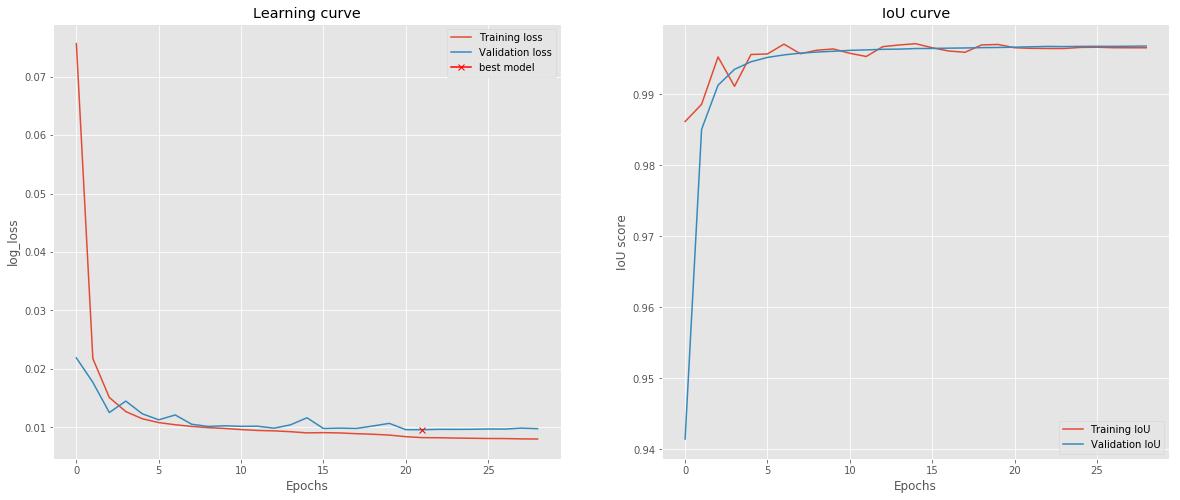

In [25]:
# Visualise the results of training
# Variables stored in results.history: val_loss, val_acc, val_IoU, loss, acc, IoU, lr
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(resultsF.history["loss"], label="Training loss")
ax[0].plot(resultsF.history["val_loss"], label="Validation loss")
ax[0].set_title('Learning curve')
ax[0].plot( np.argmin(resultsF.history["val_loss"]), np.min(resultsF.history["val_loss"]), marker="x", color="r", label="best model")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("log_loss")
ax[0].legend();

ax[1].plot(resultsF.history["val_IoU"], label="Training IoU")
ax[1].plot(resultsF.history["IoU"], label="Validation IoU")
ax[1].set_title("IoU curve")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU score")
ax[1].legend();

In [3]:
# # Evaluate on validation set (loss, acc, IoU)
# modelF.evaluate(X_validF, y_validF, verbose=2)

In [13]:
# Predict on training and validations sets
preds_trainF = modelF.predict(X_trainF, verbose=1)
preds_valF = modelF.predict(X_validF, verbose=1)

# Threshold predictions (only keep predictions with a minimum level of confidence)
preds_train_tF = (preds_trainF > 0.5).astype(np.uint8)
preds_val_tF = (preds_valF > 0.5).astype(np.uint8)

32/32 [==============================] - 0s 15ms/step
